In [2]:
import numpy as np
from sklearn.decomposition import PCA
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import normalize
from scipy import interpolate
import json

In [4]:
normal_pc = np.load("../../data/SWaT/normal_pc.npy")
anomaly_pc = np.load("../../data/SWaT/anomaly_pc.npy")

In [49]:
normal_len = len(normal_pc)
anomaly_len = len(anomaly_pc)
dimension = normal_pc.shape[1]
sample_size = 30

# Train
train_sample_step = 7
train_size = (normal_len-sample_size)//train_sample_step
print("train_sample_step: ", train_sample_step, ", train_size: ", train_size)

train_x = np.zeros((train_size, sample_size, dimension), dtype="double")
for i in range(train_size):
    train_x[i, :, :] = normal_pc\
    [i*train_sample_step: (i*train_sample_step+sample_size), :]
train_y = np.zeros((train_size, sample_size*dimension), dtype = "double")
for i in range(train_size):
    train_y[i] = train_x[i,:,:].ravel()

train_sample_step:  7 , train_size:  70710


In [6]:
test_sample_step=2
test_size = (anomaly_len-sample_size)//test_sample_step
print("test_sample_step: ", test_sample_step)
test_index = np.array([i*test_sample_step for i in range(test_size)])
test_x = np.zeros((test_size, sample_size, dimension), dtype = "double")
for i in range(test_size):
    test_x[i,:,:] = anomaly_pc[test_index[i]:(test_index[i]+sample_size), :-1]
test_y = np.zeros((test_size, sample_size*dimension), dtype = "double")
for i in range(test_size):
    test_y[i] = test_x[i,:,:].ravel()
test_attack_level = np.array([np.mean(anomaly_pc\
                                      [i:(i+sample_size), -1]) for i in test_index])

test_sample_step:  2


In [7]:
data_dim = sample_size * dimension
print("data_dim:", data_dim)

# change the output layer to relu, add linear
model_relu_linear = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape=(sample_size,dimension)),
    tf.keras.layers.Dense(200, activation=tf.nn.relu),
    
    tf.keras.layers.Dense(100, activation=tf.nn.relu),
    tf.keras.layers.Dense(50, activation=tf.nn.relu),
    
    tf.keras.layers.Dense(100, activation=tf.nn.relu),
    tf.keras.layers.Dense(400, activation=tf.nn.relu),
    tf.keras.layers.Dense(sample_size*dimension, activation=tf.nn.relu),
    tf.keras.layers.Dense(sample_size*dimension)
])
#adam = tf.keras.optimizers.Adam(lr=0.001, decay=1e-6)
model_relu_linear.compile(optimizer="Adam",
              loss=tf.keras.losses.mean_squared_error,
               metrics=["mse"])
model_relu_linear.fit(train_x, train_y, epochs=5)

#res = eval_model(get_pred_errors(model3, test_x, test_y), test_attack_level, th_int=0.01)
#print(max(res["F1"])) 

W0901 15:00:18.784717 4740949440 deprecation.py:506] From /Users/e0446225/anaconda3/lib/python3.7/site-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


data_dim: 900
Epoch 1/5
49497/49497 [==============================] - 17s 339us/sample - loss: 0.0034 - mean_squared_error: 0.0034
Epoch 2/5
49497/49497 [==============================] - 16s 323us/sample - loss: 0.0012 - mean_squared_error: 0.0012
Epoch 3/5
49497/49497 [==============================] - 16s 324us/sample - loss: 0.0012 - mean_squared_error: 0.0012
Epoch 4/5
49497/49497 [==============================] - 16s 323us/sample - loss: 8.7869e-04 - mean_squared_error: 8.7869e-04
Epoch 5/5
49497/49497 [==============================] - 16s 324us/sample - loss: 8.3356e-04 - mean_squared_error: 8.3356e-04


In [51]:
model_relu_linear.fit(train_x, train_y, epochs=5)

Epoch 1/5
70710/70710 [==============================] - 24s 337us/sample - loss: 4.7931e-04 - mean_squared_error: 4.7931e-04
Epoch 2/5
70710/70710 [==============================] - 24s 334us/sample - loss: 5.0849e-04 - mean_squared_error: 5.0849e-04
Epoch 3/5
70710/70710 [==============================] - 23s 332us/sample - loss: 4.3337e-04 - mean_squared_error: 4.3337e-04
Epoch 4/5
70710/70710 [==============================] - 24s 334us/sample - loss: 4.5249e-04 - mean_squared_error: 4.5249e-04
Epoch 5/5
70710/70710 [==============================] - 24s 333us/sample - loss: 4.6276e-04 - mean_squared_error: 4.6276e-04


In [57]:
train_pred = model_relu_linear.predict(train_x)
train_pred_mse = np.array([mean_squared_error(train_y[i], train_pred[i]) for i in range(len(train_y))])
pd.Series(train_pred_mse).describe()
test_pred = model_relu_linear.predict(test_x)
test_pred_mse = np.array([mean_squared_error(test_y[i], test_pred[i])for i in range(len(test_y))])
pd.Series(test_pred_mse).describe()
print("corr in test: ", np.corrcoef(test_pred_mse, test_attack_level))
res = {}
for i in np.linspace(np.mean(test_pred_mse)-np.std(test_pred_mse),np.mean(test_pred_mse)+3*np.std(test_pred_mse), 100):
    res[str(i)] = eval_measure(test_attack_level, test_pred_mse, test_th=0.02, pred_th=i)
    print("pred_th = ",i, ", pre, rec, f1 =",res[str(i)])
#with open()

corr in test:  [[1.         0.31475332]
 [0.31475332 1.        ]]
pred_th =  0.06127990259534294 , pre, rec, f1 = (0.16032649837079946, 0.8875122982181248, 0.2715908964194516)
pred_th =  0.073820081104131 , pre, rec, f1 = (0.1610484660790386, 0.8868199540866524, 0.27259337249872595)
pred_th =  0.08636025961291909 , pre, rec, f1 = (0.16445812123389345, 0.884123455890391, 0.27732946232626193)
pred_th =  0.09890043812170715 , pre, rec, f1 = (0.16556159842185295, 0.8807710527274715, 0.2787294521930153)
pred_th =  0.11144061663049523 , pre, rec, f1 = (0.1676218960840231, 0.8781474328608389, 0.28150899756443726)
pred_th =  0.1239807951392833 , pre, rec, f1 = (0.17010535557506584, 0.8754509346645775, 0.2848605931977306)
pred_th =  0.13652097364807136 , pre, rec, f1 = (0.17090097286810646, 0.8731188281164596, 0.2858506266142549)
pred_th =  0.14906115215685944 , pre, rec, f1 = (0.17066674345278374, 0.8638997194184309, 0.2850255775230378)
pred_th =  0.16160133066564752 , pre, rec, f1 = (0.171268

pred_th =  1.0017932907544482 , pre, rec, f1 = (0.2857142857142857, 7.28783296286849e-05, 0.00014571948998178504)
TP+FP==0
pred_th =  1.0143334692632364 , pre, rec, f1 = (0, 0, 0)
TP+FP==0
pred_th =  1.0268736477720244 , pre, rec, f1 = (0, 0, 0)
TP+FP==0
pred_th =  1.0394138262808126 , pre, rec, f1 = (0, 0, 0)
TP+FP==0
pred_th =  1.0519540047896005 , pre, rec, f1 = (0, 0, 0)
TP+FP==0
pred_th =  1.0644941832983887 , pre, rec, f1 = (0, 0, 0)
TP+FP==0
pred_th =  1.0770343618071767 , pre, rec, f1 = (0, 0, 0)
TP+FP==0
pred_th =  1.089574540315965 , pre, rec, f1 = (0, 0, 0)
TP+FP==0
pred_th =  1.1021147188247529 , pre, rec, f1 = (0, 0, 0)
TP+FP==0
pred_th =  1.114654897333541 , pre, rec, f1 = (0, 0, 0)
TP+FP==0
pred_th =  1.127195075842329 , pre, rec, f1 = (0, 0, 0)
TP+FP==0
pred_th =  1.1397352543511172 , pre, rec, f1 = (0, 0, 0)
TP+FP==0
pred_th =  1.1522754328599052 , pre, rec, f1 = (0, 0, 0)
TP+FP==0
pred_th =  1.1648156113686934 , pre, rec, f1 = (0, 0, 0)
TP+FP==0
pred_th =  1.177355789

In [54]:
pd.Series(test_pred_mse).describe()

count    224944.000000
mean          0.243195
std           0.213613
min           0.000080
25%           0.006329
50%           0.258227
75%           0.396628
max           0.768802
dtype: float64

In [55]:
np.linspace(1,10,20)

array([ 1.        ,  1.47368421,  1.94736842,  2.42105263,  2.89473684,
        3.36842105,  3.84210526,  4.31578947,  4.78947368,  5.26315789,
        5.73684211,  6.21052632,  6.68421053,  7.15789474,  7.63157895,
        8.10526316,  8.57894737,  9.05263158,  9.52631579, 10.        ])

In [53]:
np.std(test_pred_mse)

0.2136123974691586

corr in test:  [[1.         0.38299184]
 [0.38299184 1.        ]]


count    224944.000000
mean          0.243195
std           0.213613
min           0.000080
25%           0.006329
50%           0.258227
75%           0.396628
max           0.768802
dtype: float64

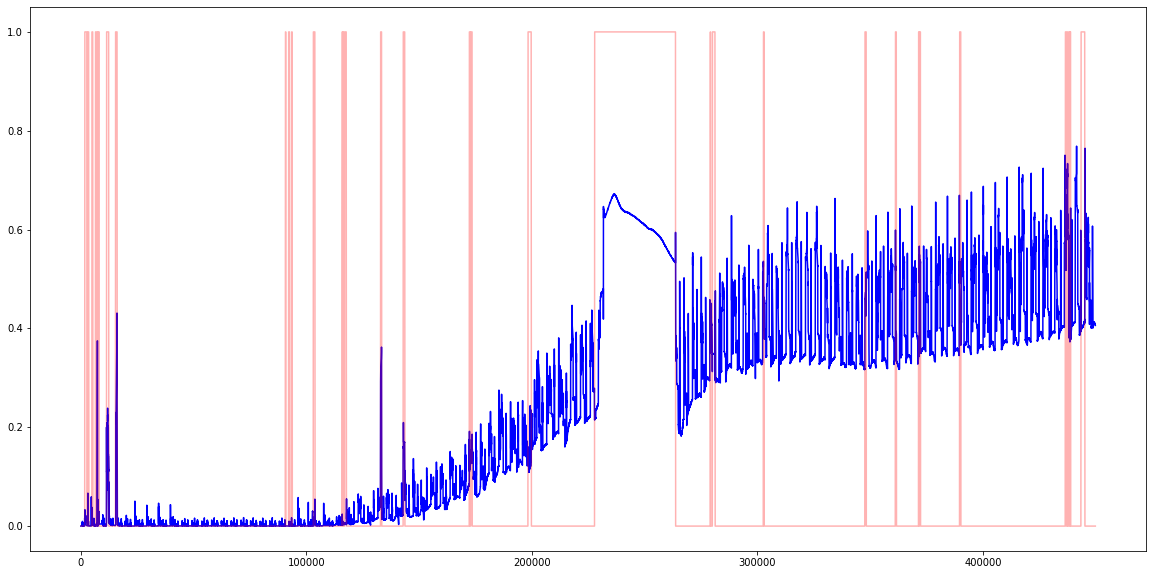

In [46]:
plt.figure(figsize=(20,10))
plt.plot(test_index, test_pred_mse, color ="b")
plt.plot(test_index, test_attack_level, color = "r", alpha=0.3)

In [27]:
def eval_measure(test, pred, test_th = 0.02, pred_th = 0.24):
    TP, FP, TN, FN = 0,0,0,0
    for i in range(len(test)):
        if(test[i] >test_th):
            if(pred[i]>pred_th):
                TP+=1
            elif(pred[i]<=pred_th):
                FN +=1
        elif(test[i]<=test_th):
            if(pred[i]>pred_th):
                FP +=1
            elif(pred[i]<=pred_th):
                TN+=1
    if(TP+FP==0):
        print("TP+FP==0")
        return (0,0,0)
    if(TP+FN==0):
        print("TP+FN==0")
        return (0,0,0)

    pre = TP/(TP+FP)   
    rec = TP/(TP+FN)
    F1 = 2*pre*rec/(pre+rec)
    #print("pre: ", pre, ";  rec: ", rec, "; F1: ", F1)
    return (pre, rec, F1)    

i:  0.5
(0.5026173338885254, 0.6157854461975731, 0.553475804470646)
i:  0.505
(0.5184000983798075, 0.6144371970994424, 0.5623478405869601)
i:  0.51
(0.5362401988908013, 0.6130525088364974, 0.5720795008245915)
i:  0.515
(0.5541146967597176, 0.6119228947272528, 0.5815858283260317)
i:  0.52
(0.5727512773910359, 0.6086069307291477, 0.5901349727934422)
i:  0.525
(0.591962795981398, 0.6076230732791604, 0.5996907142343378)
i:  0.53
(0.6081740470337895, 0.6040520351273548, 0.6061060329067641)
i:  0.535
(0.6192195159022685, 0.5938126298145247, 0.60625)
i:  0.54
(0.6352404941825597, 0.5789454505702729, 0.60578792847066)
i:  0.545
(0.6565780562140197, 0.5652078854352658, 0.6074764525035737)
i:  0.55
(0.6782488149539397, 0.552672812739132, 0.6090553157313524)
i:  0.555
(0.7012226785629986, 0.5412673541522428, 0.6109488750874018)
i:  0.56
(0.7202575532441803, 0.529898334730168, 0.6105850985661202)
i:  0.5650000000000001
(0.7380767438247631, 0.519367416098823, 0.6097018436925183)
i:  0.5700000000000

In [36]:
start = []
end = []
for i in range(anomaly_pc.shape[0]-1):
    if(anomaly_pc[i][-1]==0 and anomaly_pc[i+1][-1]==1):
        #print("0->1", i, i+1)
        start.append(i+1)
    elif(anomaly_pc[i][-1]==1 and anomaly_pc[i+1][-1]==0):
        #print("1->0", i, i+1)
        end.append(i+1)

attack_ = np.concatenate((start, end)).reshape(2, len(start)).transpose(1,0)

In [37]:
print(attack_)

[[  1754   2694]
 [  3068   3511]
 [  4920   5303]
 [  6459   6849]
 [  7255   7451]
 [  7705   8134]
 [ 11410  12374]
 [ 15380  16101]
 [ 90685  90918]
 [ 92140  92571]
 [ 93445  93721]
 [103092 103809]
 [115843 116102]
 [116143 116538]
 [117000 117721]
 [132918 133381]
 [142954 143651]
 [172268 172589]
 [172910 173522]
 [198296 199741]
 [227828 263728]
 [279120 279241]
 [280060 281231]
 [302653 303020]
 [347679 348280]
 [361191 361635]
 [371479 371580]
 [371855 372336]
 [389680 390220]
 [436541 437010]
 [437417 437698]
 [438147 438548]
 [438621 438918]
 [443501 445191]]


In [41]:
# prepare to visualize the predicted values
vis_nums = [0]
rec_step = sample_size//test_sample_step
pred_y_data = np.zeros((anomaly_pc.shape[0], anomaly_pc.shape[1]-1))
for vis_num in vis_nums:
    max_j = np.min(((anomaly_pc.shape[0]-vis_num*test_sample_step)//sample_size, (test_pred.shape[0]-vis_num)//rec_step))
    for j in range(max_j):
        #if(vis_num+j)
        pred_y_data[(vis_num*test_sample_step + j*sample_size):(vis_num*test_sample_step+(j+1)*sample_size),:] \
            =test_pred[vis_num+j*rec_step].reshape(sample_size,dimension)

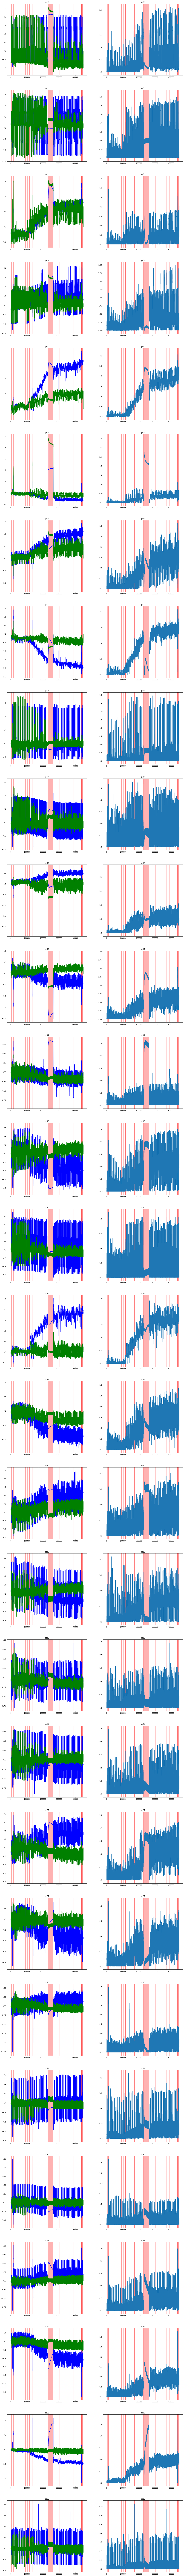

In [43]:
plt.figure(figsize=(20,10*normal_pc.shape[1]))

range2 = np.arange(0, anomaly_pc.shape[0])
for i in range(normal_pc.shape[1]):
    plt.subplot(normal_pc.shape[1], 2, 2*i+1)
    plt.plot(range2, anomaly_pc[range2,:][:,i],color="b")
    plt.plot(range2, pred_y_data[range2,:][:,i], color ="g")
    for j in range(len(start)):
        if(start[j] in range2 or end[j] in range2):
            plt.axvspan(start[j], end[j], alpha=0.3, color='red')
    plt.title("pc"+str(i))
            
    plt.subplot(normal_pc.shape[1], 2, 2*i+2)
    plt.plot(range2, np.abs(anomaly_pc[range2,:][:,i]-pred_y_data[range2,:][:,i]))
    for j in range(len(start)):
        if(start[j] in range2 or end[j] in range2):
            plt.axvspan(start[j], end[j], alpha=0.3, color='red')
    plt.title("pc"+str(i))

In [6]:
def get_eval(ground_truth, pred_val):
    assert ground_truth.shape == pred_val.shape
    TP, FP, TN, FN = 0,0,0,0
    gth = ground_truth.ravel()
    pred = pred_val.ravel()
    for i in range(len(gth)):
        if(gth[i] >0.5):
            if(pred[i]>0.5):
                TP+=1
            elif(pred[i]<=0.5):
                FN +=1
        elif(gth[i]<=0.5):
            if(pred[i]>0.5):
                FP +=1
            elif(pred[i]<=0.5):
                TN+=1
    if(TP+FP==0):
        print("TP+FP==0")
        return (0,0,0)
    if(TP+FN==0):
        print("TP+FN==0")
        return (0,0,0)
    pre = TP/(TP+FP)   
    rec = TP/(TP+FN)
    F1 = 2*pre*rec/(pre+rec)
    #print("pre: ", pre, ";  rec: ", rec, "; F1: ", F1)
    return (pre, rec, F1)    
def get_pred_errors(model, test_x, test_y):
    test_pred = model.predict(test_x)
    return np.array([mean_squared_error(test_y[i], test_pred[i]) for i in range(len(test_y))])

def eval_model(errors, attack_levels, th_int=0.1, attack_th=0.3):
    #err_normalized = normalize_1d(errors)
    thresholds = np.arange(0.5*th_int,1,th_int)
    print("corr: ", np.corrcoef(err_normalized, attack_levels))
    attack_th = np.array([1 if i>attack_th else 0 for i in attack_levels])
    
    normal_err = np.array([err_normalized[i] for i in range(len(err_normalized)) if attack_th[i]==0])
    anomaly_err = np.array([err_normalized[i] for i in range(len(err_normalized)) if attack_th[i]==1])
    print("normal_err: ", pd.Series(normal_err).describe())
    print("anomaly_err:", pd.Series(anomaly_err).describe())
    
    
    res = {"th":np.zeros((len(thresholds))),"pre":np.zeros((len(thresholds))), "rec":np.zeros((len(thresholds))), "F1":np.zeros((len(thresholds)))}
    for i in range(len(thresholds)):
        th = thresholds[i]
        #print("Threshold = ", th)
        err_thd = np.array([1 if i >th else 0 for i in err_normalized])
        pre, rec, F1=get_eval(attack_th, err_thd)
        res["th"][i]=th
        res["pre"][i]=pre
        res["rec"][i] = rec
        res["F1"][i] = F1
    plt.subplot(1,3,1)
    plt.plot(thresholds, res["pre"])
    plt.xlabel("threshold")
    plt.ylabel("pre")
    plt.title("pre")
    
    plt.subplot(1,3,2)
    plt.plot(thresholds, res["rec"])
    plt.xlabel("threshold")
    plt.ylabel("rec")
    plt.title("rec")
    
    plt.subplot(1,3,3)
    plt.plot(thresholds, res["F1"])
    plt.xlabel("threshold")
    plt.ylabel("F1")
    plt.title("F1")
    return res